In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import entropy  # For noise measurement
import re
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Assuming 'device' is defined as torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
# Step 1: Load and Preprocess Data
# Load data from Sheet2 (adjust path if needed)
df = pd.read_excel('/Users/myronkneip/nitter_scraper/Final/Training_data.xlsx', sheet_name='Sheet1')

# Sort by timestamp for sequential analysis
df = df.sort_values('Timestamp').reset_index(drop=True)  # Assume 'Timestamp' column

# Clean text (remove links, etc.)
df['Tweet_clean'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+|www\S+', '', str(x)).strip())

print("Data Loaded and Sorted. Shape:", df.shape)
df.head()

Data Loaded and Sorted. Shape: (11854, 33)


,tweet_ID,Timestamp,Twitter_acc,Tweet,Mid_Open_Execution,Execution_Delayed,MI_1min_MidOpen,MI_1min_MidClose,MI_5min_MidOpen,MI_5min_MidClose,...,MI_12h_MidClose,MI_1d_MidOpen,MI_1d_MidClose,MI_2d_MidOpen,MI_2d_MidClose,MI_3d_MidOpen,MI_3d_MidClose,MI_4d_MidOpen,MI_4d_MidClose,Tweet_clean
0,9795,2024-12-09 06:13:00,SStapczynski,Nuclear power isn’t a cost-effective solution ...,67.620,False,-2.218279,-3.697131,-2.218279,-0.739426,...,144.188110,47.323277,46.583851,213.694173,215.173026,414.818101,417.775806,365.276545,364.537119,Nuclear power isn’t a cost-effective solution ...
1,9498,2024-12-09 07:58:00,OilSheppard,Turkish construction sector shares the joy of ...,67.950,False,0.735835,-2.207506,-4.415011,-6.622517,...,47.829286,18.395879,18.395879,115.526122,116.997792,367.181751,370.860927,350.993377,350.993377,Turkish construction sector shares the joy of ...
2,10711,2024-12-09 08:27:00,IDF,⭕️A UAV that was likely launched from Yemen hi...,68.225,False,-2.931477,-9.527299,-14.657384,-11.725907,...,-5.862953,5.130084,0.732869,76.951264,82.814218,341.517039,342.982778,291.681935,291.681935,⭕️A UAV that was likely launched from Yemen hi...
3,13556,2024-12-09 09:30:00,OPECSecretariat,#PetroleumProducts #WindTurbine,68.015,False,-4.410792,-0.735132,5.881056,2.940528,...,23.524223,31.610674,27.935014,181.577593,183.782989,374.917298,379.328089,328.603984,341.101228,#PetroleumProducts #WindTurbine
4,11450,2024-12-09 13:50:00,SStapczynski,India Energy Week 2025 is excited to welcome S...,68.195,False,4.399149,13.197448,23.462131,17.596598,...,2.932766,13.197448,4.399149,187.697045,193.562578,319.671530,325.537063,324.070680,322.604297,India Energy Week 2025 is excited to welcome S...


In [4]:
# Step 2: Topic Detection (Keywords + ML Clustering)
oil_keywords = ['Explosions', 'Tehran', 'Israel', 'Missile', 'Strike', 'WTI', 'oil', 'crude', 'energy', 'Iran', 'nuclear', 'Trump', 'Netanyahu']  # Expanded for better detection

# Function to flag oil-related tweets
def is_oil_topic(text):
    return any(word.lower() in text.lower() for word in oil_keywords)

df['is_oil_topic'] = df['Tweet_clean'].apply(is_oil_topic)

# ML Topic Modeling: Use TF-IDF + KMeans for clustering topics over time
vectorizer = TfidfVectorizer(lowercase=False, stop_words='english', max_features=200, min_df=1)
tfidf_matrix = vectorizer.fit_transform(df['Tweet_clean'])

# Cluster into topics (e.g., 5 clusters; adjust based on data)
kmeans = KMeans(n_clusters=5, random_state=42)
df['topic_cluster'] = kmeans.fit_predict(tfidf_matrix)

# Alternative: LDA for probabilistic topics
lda = LDA(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)
df['lda_topic'] = np.argmax(lda_topics, axis=1)  # Dominant topic

print("Topic Detection Complete.")
df[['Tweet_clean', 'is_oil_topic', 'topic_cluster', 'lda_topic']].head(10)

Topic Detection Complete.


,Tweet_clean,is_oil_topic,topic_cluster,lda_topic
0,Nuclear power isn’t a cost-effective solution ...,True,4,2
1,Turkish construction sector shares the joy of ...,False,0,1
2,⭕️A UAV that was likely launched from Yemen hi...,False,0,1
3,#PetroleumProducts #WindTurbine,False,0,0
4,India Energy Week 2025 is excited to welcome S...,True,2,4
5,#OPEC,False,0,4
6,Japan eyes fossil fuels for up to 40% of its p...,False,0,2
7,"On this day eight years ago, OPEC Member Count...",True,0,2
8,COFFEE PRICES HIT RECORD HIGH ☕🚨\n\n🔥 Mounting...,False,4,2
9,في يوم حقوق الإنسان، نواجه واقعا أليما.\nفحقوق...,False,0,2


Trade Entry Points (>=5 Accounts on Oil Topic):


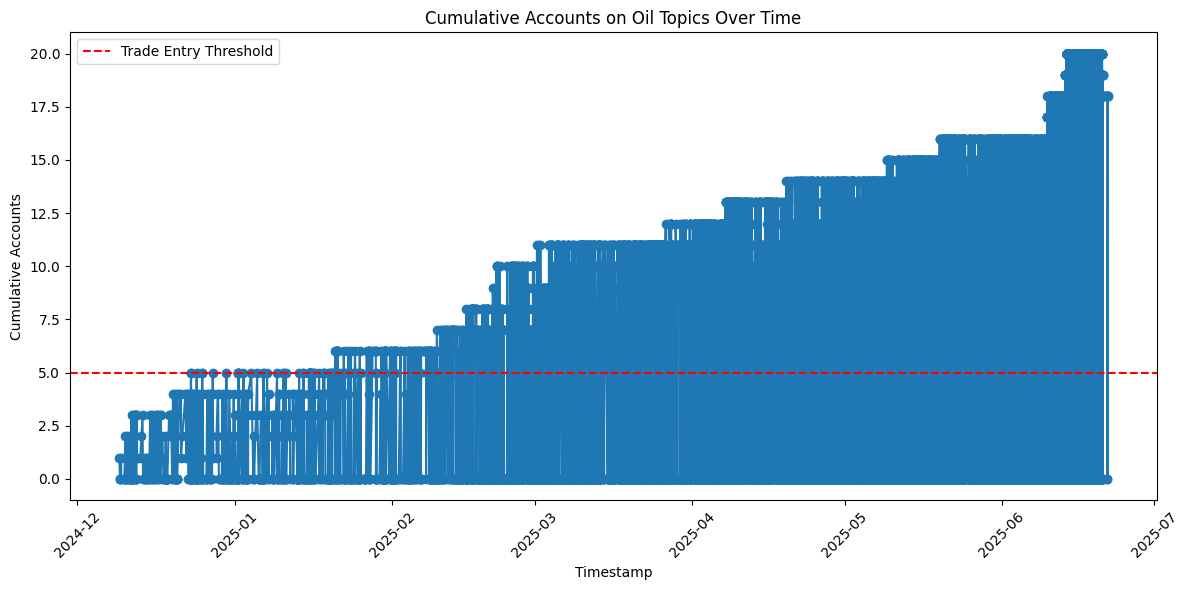

In [5]:
# Step 3: Sequential Analysis - Cumulative Accounts per Topic
# Cumulative tracking: Scan tweet by tweet, track unique accounts per topic
df['cumulative_oil_accounts'] = 0
df['current_topic_accounts'] = ''

# Dictionary to track accounts per topic (use LDA topic)
topic_accounts = {}  # topic: set of accounts

for idx, row in df.iterrows():
    topic = row['lda_topic']  # Or 'topic_cluster'
    acc = row['Twitter_acc']
    
    if row['is_oil_topic']:
        if topic not in topic_accounts:
            topic_accounts[topic] = set()
        topic_accounts[topic].add(acc)
        
        df.at[idx, 'cumulative_oil_accounts'] = len(topic_accounts[topic])
        df.at[idx, 'current_topic_accounts'] = ', '.join(topic_accounts[topic])
    
    # Optional: Reset logic for narrative shifts can be added here (e.g., per day)

# Trade entry points: Where cumulative >=5
trade_entries = df[df['cumulative_oil_accounts'] >= 5]

print("Trade Entry Points (>=5 Accounts on Oil Topic):")
trade_entries[['Timestamp', 'Twitter_acc', 'Tweet_clean', 'cumulative_oil_accounts', 'current_topic_accounts', 'lda_topic']]

# Plot cumulative accounts over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['cumulative_oil_accounts'], marker='o')
plt.axhline(y=5, color='r', linestyle='--', label='Trade Entry Threshold')
plt.title('Cumulative Accounts on Oil Topics Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Accounts')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Narrative Shift Points (Low Noise):


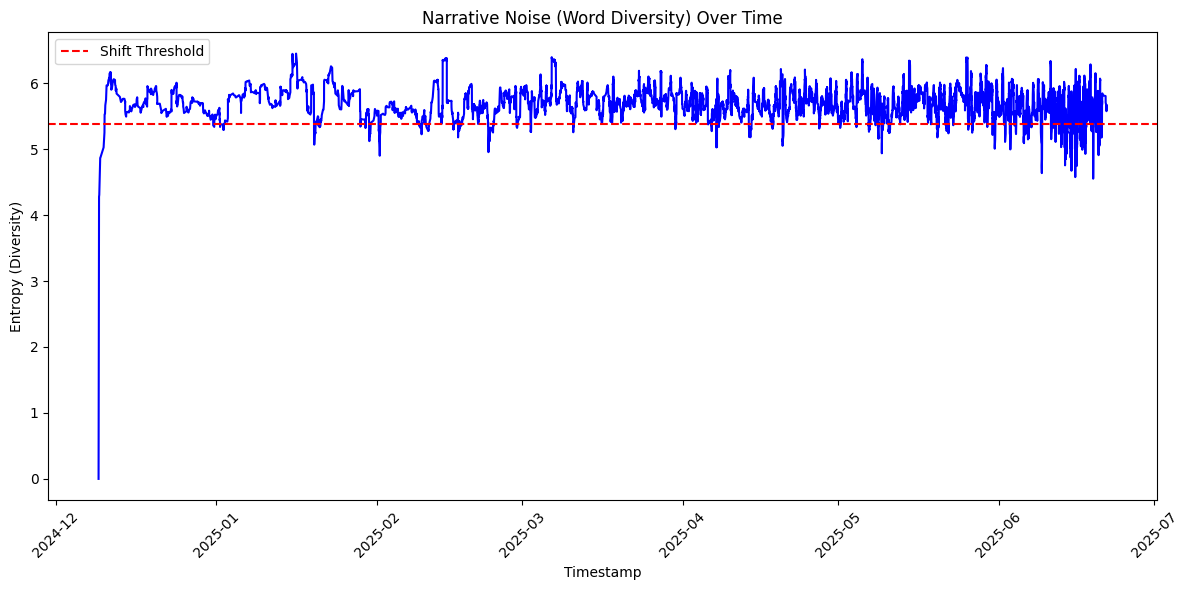

In [12]:
# Step 4: Narrative Shift Detection with Rolling Entropy
# Measure noise: Word diversity (entropy) in rolling windows
window_size = 20  # Tweets per window; adjust
df['word_diversity'] = 0.0

# Manual rolling computation for entropy
def compute_rolling_entropy(df, col='Tweet_clean', window_size=20):
    entropy_values = []
    for i in range(len(df)):
        start = max(0, i - window_size + 1)
        window = df[col].iloc[start:i+1]
        window = [str(t) for t in window]  # Ensure strings
        if len(window) < 2:
            entropy_values.append(0.0)
            continue
        word_counts = pd.Series(' '.join(window).split()).value_counts(normalize=True)
        entropy_values.append(entropy(word_counts))
    return entropy_values

df['word_diversity'] = compute_rolling_entropy(df, window_size=window_size)

# Handle NaNs in entropy
df['word_diversity'] = df['word_diversity'].fillna(0)

# Shift point: Where diversity drops significantly (e.g., below mean - std)
mean_div = df['word_diversity'].mean()
std_div = df['word_diversity'].std()
shift_points = df[df['word_diversity'] < (mean_div - std_div)]

print("Narrative Shift Points (Low Noise):")
shift_points[['Timestamp', 'Tweet_clean', 'word_diversity', 'lda_topic']]

# Plot diversity over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['word_diversity'], color='b')
plt.axhline(y=mean_div - std_div, color='r', linestyle='--', label='Shift Threshold')
plt.title('Narrative Noise (Word Diversity) Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Entropy (Diversity)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Step 5: Integrate BERT Embeddings for Enhanced Features
# BERT for tweet embeddings (NLP features)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embedding(tweet):
    if not isinstance(tweet, str):
        return np.zeros(768)
    inputs = tokenizer(tweet, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

df['BERT_Embedding'] = df['Tweet_clean'].apply(get_bert_embedding)

# Stack embeddings into array
embeddings = np.stack(df['BERT_Embedding'].values)

# Add hybrid features: entropy, cumulative accounts, topic as one-hot, etc.
# One-hot encode LDA topics
lda_onehot = pd.get_dummies(df['lda_topic'], prefix='lda_topic')
features = np.hstack([embeddings, df[['word_diversity', 'cumulative_oil_accounts']].values, lda_onehot.values])

print("Hybrid Features Shape:", features.shape)

Hybrid Features Shape: (11854, 775)


MI Diffs at Trade Entries:


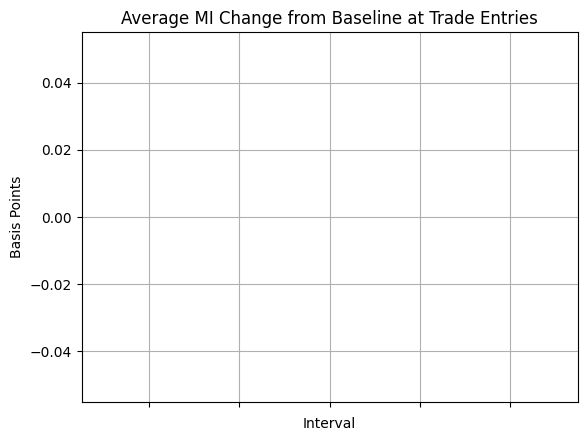

In [8]:
# Step 6: Integrate with Market Impact (MI Diffs from Baseline)
# Assume MI columns exist; compute diffs
intervals = ['1min', '5min', '15min', '30min', '1h', '2h', '4h', '8h', '12h', '1d', '2d', '3d', '4d']
df['MI_Baseline'] = df.get('MI_1min_MidOpen', pd.Series(0, index=df.index))  # Fallback if missing
for interval in intervals[1:]:
    open_col = f'MI_{interval}_MidOpen'
    if open_col in df.columns:
        df[f'MI_{interval}_FromBaseline'] = df[open_col] - df['MI_Baseline']
    else:
        df[f'MI_{interval}_FromBaseline'] = np.nan

diff_cols = [f'MI_{interval}_FromBaseline' for interval in intervals[1:] if f'MI_{interval}_FromBaseline' in df.columns]

# At trade entries, show MI diffs (select only existing columns)
existing_diff_cols = [col for col in diff_cols if col in trade_entries.columns]
entry_mi = trade_entries[['Timestamp', 'Twitter_acc', 'Tweet_clean', 'cumulative_oil_accounts'] + existing_diff_cols]

print("MI Diffs at Trade Entries:")
entry_mi

# Average MI diffs at entries over intervals (handle NaNs)
entry_avg = entry_mi[existing_diff_cols].mean()
entry_avg.plot(kind='line', marker='o', title='Average MI Change from Baseline at Trade Entries')
plt.ylabel('Basis Points')
plt.xlabel('Interval')
plt.grid(True)
plt.show()


In [9]:
# Step 7: Prepare for ML (Targets Cleaning and Scaling)
# Targets: MI columns
mi_columns = [col for col in df.columns if col.startswith('MI_') and col != 'MI_Baseline']  # Exclude baseline

# Handle NaNs and infs in raw targets
df[mi_columns] = df[mi_columns].fillna(0).replace([np.inf, -np.inf], 0)

targets = df[mi_columns].values

# Fit scaler and identify zero-variance columns
target_scaler = StandardScaler().fit(targets)
zero_var_mask = target_scaler.var_ > 0

if np.any(~zero_var_mask):
    zero_var_columns = [mi_columns[i] for i in np.where(~zero_var_mask)[0]]
    print("Removing zero-variance MI columns:", zero_var_columns)
    mi_columns = [col for i, col in enumerate(mi_columns) if zero_var_mask[i]]
    targets = targets[:, zero_var_mask]
    target_scaler = StandardScaler().fit(targets)

# Scale features and targets
feature_scaler = StandardScaler().fit(features)
features_scaled = feature_scaler.transform(features)
targets_scaled = target_scaler.transform(targets)

# Final NaN cleanup
targets_scaled = np.nan_to_num(targets_scaled, nan=0.0)

# NaN checks and shapes
print("NaNs in features_scaled:", np.isnan(features_scaled).any())
print("NaNs in targets_scaled:", np.isnan(targets_scaled).any())
print("Features shape:", features_scaled.shape)
print("Targets shape:", targets_scaled.shape)

# Optional: Split for training (use full df as train here; add test if separate)
X_train, X_val, y_train, y_val = train_test_split(features_scaled, targets_scaled, test_size=0.2, shuffle=False)

NaNs in features_scaled: False
NaNs in targets_scaled: False
Features shape: (11854, 775)
Targets shape: (11854, 38)
